In [1]:
from cv_loader import *
import numpy as np 
import torch
from torch import nn

/Users/shashanksule/Documents/CV_learning/butane_AE/feature_map_align_12_carbons


In [2]:
featurizer = get_featurizer()
coord_chart = get_chart()
cv_model_1 = get_cv_1()
cv_model_2 = get_cv_2()
model_Psi = get_SDF()

In [3]:
# full cv 
class collective_variable(nn.Module):
    def __init__(self, featurizer, embedding, collective_var): 
        super(collective_variable, self).__init__()
        self.featurizer = featurizer
        self.embedding = embedding
        self.collective_var = collective_var
    def forward(self,x):
        # multiply by 10.0 if running openmm sim 
        featurized_carbons = self.featurizer(x)
        manifold_point = self.embedding(featurized_carbons)
        cv_val = self.collective_var(manifold_point)
        return cv_val.flatten()

In [ ]:
fname = "../ground_data/butane_nonaligned.npz" #butane_metad.npz DNMTBut.npz butane_hightemp.npz
inData = np.load(fname)
print("Keys in data:")
print(list(inData.keys()))

dataMetaD = inData["data_all_atom"]
data = dataMetaD[::10, :]
dihedrals = inData["dihedrals"][::10]

Keys in data:
['data', 'data_all_atom', 'dihedrals', 'potential', 'kbT', 'kbT_roomtemp', 'free_energy', 'biasFactor', 'biasWidth', 'height', 'frequency']


In [5]:
collective_variable_1 = collective_variable(featurizer, coord_chart, cv_model_1)
collective_variable_2 = collective_variable(featurizer, coord_chart, cv_model_2)

In [6]:
cv_1 = collective_variable_1(torch.Tensor(data)).detach().cpu().numpy()
cv_2 = collective_variable_2(torch.Tensor(data)).detach().cpu().numpy()

In [7]:
cv_2.shape

(10000,)

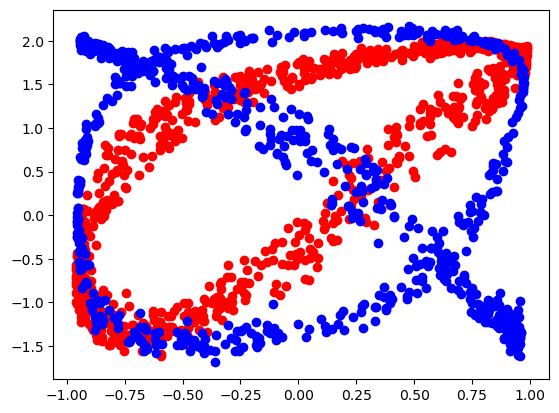

In [8]:
anti = np.abs(dihedrals-np.pi) < 0.2 
gauche = np.logical_or(np.abs(dihedrals-np.pi/3) < 0.1, np.abs(dihedrals-5*np.pi/3) < 0.1) 
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(cv_1[anti], cv_2[anti], c='r')
ax.scatter(cv_1[gauche], cv_2[gauche], c='b')

In [9]:
featurized_data = featurizer(torch.Tensor(data))

In [10]:
manifold_data = coord_chart(featurized_data)

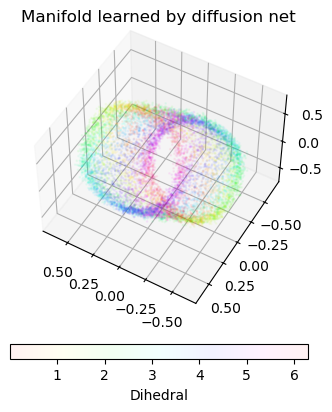

In [11]:
plotting_data = manifold_data.cpu().detach().numpy()
fig = plt.figure()
ax = fig.add_subplot(projection='3d') 
p = ax.scatter(plotting_data[:,0], plotting_data[:,1], plotting_data[:,2], \
           c=dihedrals, cmap='hsv', s=1.0, alpha=0.05)
ax.set_title("Manifold learned by diffusion net")
ax.view_init(elev=50, azim=120, roll=0)
fig.colorbar(p,location='bottom', shrink=0.6, pad=0.1, label='Dihedral')

In [18]:
# get gradients 
manifold_data.requires_grad_(True)
psi_vals = model_Psi(manifold_data)
grads = torch.autograd.grad(psi_vals.sum(), manifold_data, create_graph=True)[0]
grads_0 = torch.autograd.grad(psi_vals.sum(), manifold_data, create_graph=True)[0][:,0]
hessians = torch.autograd.grad(grads_0.sum(), manifold_data, create_graph=True)[0]

In [19]:
grads.shape

torch.Size([10000, 3])

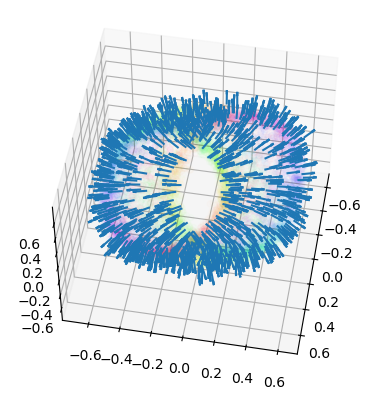

In [21]:
# plot gradients 
# plot_hessians
plot_grads = True
if plot_grads:
    ax = plt.figure().add_subplot(projection='3d')
    ax.quiver(manifold_data[::10,0].detach().numpy(), \
              manifold_data[::10,1].detach().numpy(), \
              manifold_data[::10,2].detach().numpy(), \
              -1e-1*grads[::10,0].detach().numpy(), 
              -1e-1*grads[::10,1].detach().numpy(), 
              -1e-1*grads[::10,2].detach().numpy())
    ax.scatter(manifold_data[:,0].detach().numpy(), \
               manifold_data[:,1].detach().numpy(), \
               manifold_data[:,2].detach().numpy(),\
               c=dihedrals, cmap='hsv', alpha=0.01)
    # ax.set_xlim((-0.5,0.5))
    # ax.set_ylim((-0.5,0.5))
    # ax.set_zlim((-0.5,0.5))
    ax.view_init(elev=50, azim=10, roll=0)

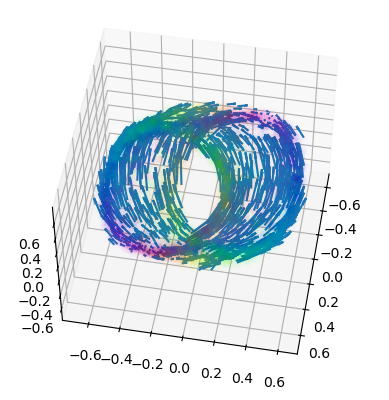

In [14]:
# plot_hessians
plot_hessians = True
if plot_hessians:
    ax = plt.figure().add_subplot(projection='3d')
    ax.quiver(manifold_data[::10,0].detach().numpy(), \
              manifold_data[::10,1].detach().numpy(), \
              manifold_data[::10,2].detach().numpy(), \
              1e-1*hessians[::10,0].detach().numpy(), 
              1e-1*hessians[::10,1].detach().numpy(), 
              1e-1*hessians[::10,2].detach().numpy())
    ax.scatter(manifold_data[:,0].detach().numpy(), \
               manifold_data[:,1].detach().numpy(), \
               manifold_data[:,2].detach().numpy(),\
               c=dihedrals, cmap='hsv', alpha=0.01)
    # ax.set_xlim((-0.5,0.5))
    # ax.set_ylim((-0.5,0.5))
    # ax.set_zlim((-0.5,0.5))
    ax.view_init(elev=50, azim=10, roll=0)